In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

filterwarnings('ignore')

In [5]:
purchases = pd.read_csv('purchases_processed.csv')
clients = pd.read_csv('clients.csv')

In [5]:
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,000048b7a6,2018-12-15 13:33:11,NaN,68,F
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


Всего клиентов в нашем датасете, и все имеют уникальный id.

In [124]:
print(clients.shape[0], clients.client_id.nunique())

400162 400162


Видим, что нет пропусков среди id клиентов, для каждого клиента столбец с датой приобретения карты лояльности заполнен, однако не все клиенты перевыпускали карты (поскольку их срок еще не закончился).

In [21]:
clients.isna().sum(axis=0)

client_id                0
first_issue_date         0
first_redeem_date    35469
age                      0
gender                   0
dtype: int64

Имеется 1145 клиентов с очевидно неверными значениями возраста. Будем учитывать это при анализе и при необходимости исключать.

In [22]:
clients[(clients.age < 0) | (clients.age > 100)].shape[0]

1145

In [6]:
sns.set_theme(style="darkgrid")

Рассмотрим половой профиль представленных клиентов. Очень многие клиенты не указали пол, это усложняет использование гендера как переменной в исследованиях, так как будем наблюдать некоторое смещение.

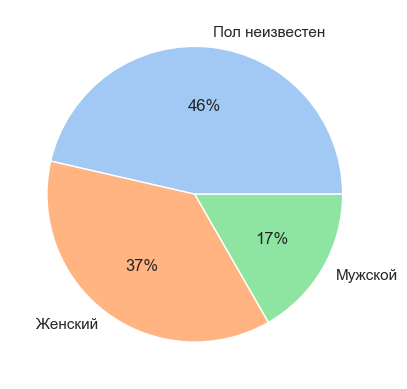

In [9]:
plt.pie(clients.gender.value_counts(), 
        labels=['Пол неизвестен', 'Женский', 'Мужской'], 
        colors=sns.set_palette('pastel'), autopct='%.0f%%')
plt.show()

In [12]:
# Оставим только дату в столбцах с приобретением и первыпуском карт
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.date
clients.first_redeem_date = pd.to_datetime(clients.first_redeem_date).dt.date

In [15]:
first_issue = clients.groupby(['first_issue_date']).client_id.count().reset_index()
first_redeem = clients.groupby(['first_redeem_date']).client_id.count().reset_index()

Рассмотрим временной ряд оформления новых карт. Видим резкие спады в начале 2018 и 2019 годов. На некоторых промежутках ряд ведет себя как стационарных, при этом ближе к концу года замечаем восходящий тренд.

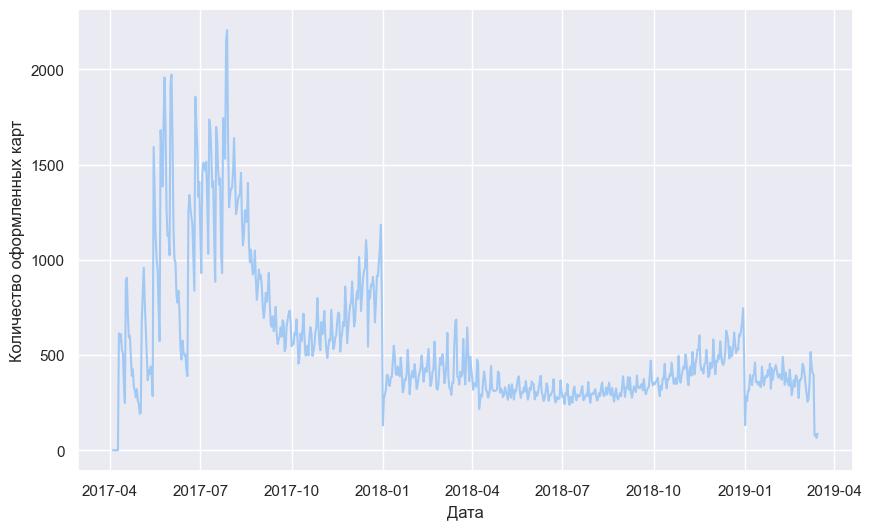

In [95]:
plt.figure(figsize=(10, 6))
sns.lineplot(first_issue, x='first_issue_date', y='client_id')
plt.xlabel('Дата')
plt.ylabel('Количество оформленных карт')
plt.show()

In [25]:
first_issue['day_of_week'] = pd.to_datetime(first_issue.first_issue_date).dt.day_of_week + 1
first_issue['year'] = pd.to_datetime(first_issue.first_issue_date).dt.year

Рассмотрим вклад каждого года в тот срез клиентов, который нам доступен в данном датасете. Так как 2018 -- единственный полный наблюдаемый год, он приносит больше всего новых клиентов.

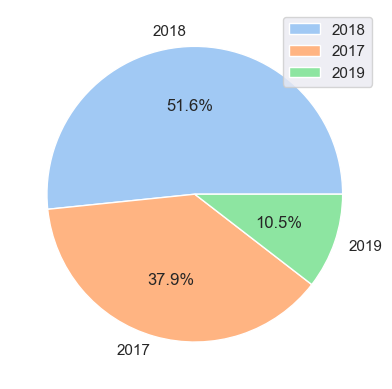

In [118]:
df_ = first_issue.year.value_counts().reset_index()
plt.pie(df_['count'], labels=df_['year'],
        colors=sns.set_palette('pastel'), autopct='%.1f%%')
plt.legend()
plt.show()

In [113]:
lst = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
dwks = {i+1: el for i, el in enumerate(lst)}

In [114]:
first_issue['day_of_week'] = first_issue['day_of_week'].apply(lambda x: dwks[x])
frst_iss = first_issue.groupby('day_of_week').client_id.mean().reset_index()
frst_iss2 = first_issue.groupby(['day_of_week', 'year']).client_id.mean().reset_index()

Проверим, как происходит оформление карт в разрезе недели: пятница -- самый популярный день. Оформление карт чаще происходит в будние дни, чем в выходные, что достаточно логично.

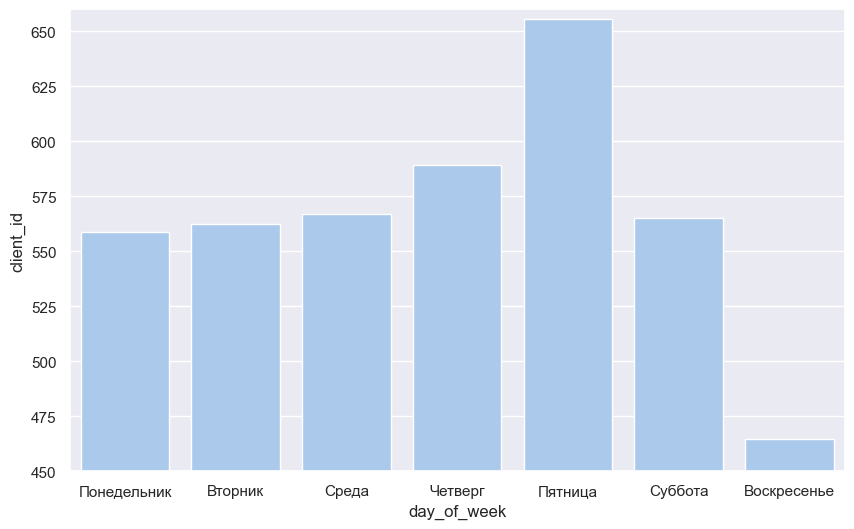

In [117]:
plt.figure(figsize=(10, 6))
sns.barplot(frst_iss, x='day_of_week', y='client_id', 
            order=["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"])
plt.ylim(450, 660)
plt.show()

In [42]:
weekly_totals = first_issue.groupby(['year', 'day_of_week'])['client_id'].sum().reset_index()
yearly_totals = first_issue.groupby('year')['client_id'].sum().reset_index()
merged = pd.merge(weekly_totals, yearly_totals, on='year', suffixes=('', '_yearly'))
merged['percentage_share'] = (merged['client_id'] / merged['client_id_yearly']) * 100
merged['day_of_week'] = merged['day_of_week'].apply(lambda x: dwks[x])

Видим, что недельная сезональность сохраняется для каждого из годов с незначительными изменениями.

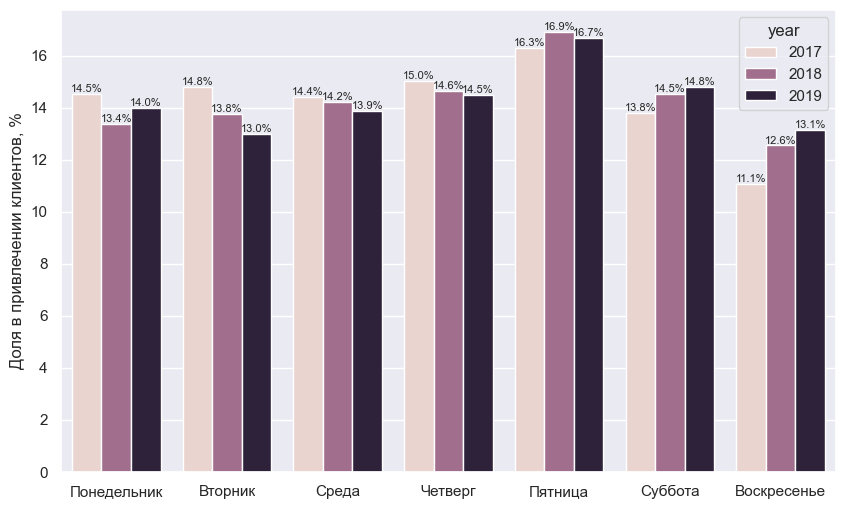

In [74]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(merged, x='day_of_week', y='percentage_share', hue='year',
                 order=["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"])
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=8)
plt.xlabel('')
plt.ylabel('Доля в привлечении клиентов, %')
plt.show()

Видим, что в перевыпуске карт не так сильно ощущается влияние смены года. Помимо некоторых выбросов ряд кажется стационарным или примерно стационарным. Выбросы наблюдаются в начале года (видимо, у многих подходит конец срока действия, либо уже вышедшие из срока карты клиенты меняют, чтобы совершать новогодние покупки). Помимо Нового года, пик находится около 8 марта.

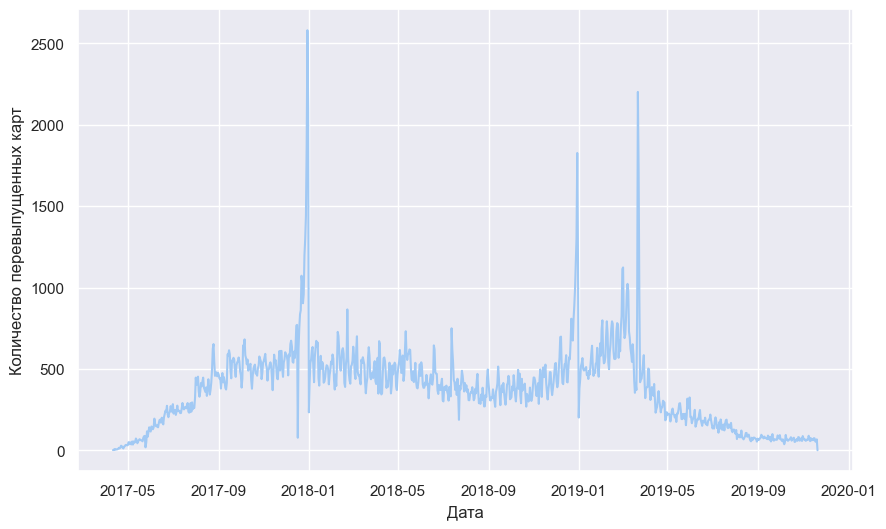

In [96]:
plt.figure(figsize=(10, 6))
plt.xlabel('Дата')
plt.ylabel('Количество перевыпущенных карт')
sns.lineplot(first_redeem, x='first_redeem_date', y='client_id')
plt.show()

In [98]:
first_redeem['day_of_week'] = pd.to_datetime(first_redeem.first_redeem_date).dt.day_of_week + 1
first_redeem['year'] = pd.to_datetime(first_redeem.first_redeem_date).dt.year
first_red = first_redeem.groupby('day_of_week').client_id.mean().reset_index()
first_red2 = first_redeem.groupby(['day_of_week', 'year']).client_id.mean().reset_index()

Рассмотрим, как изменяется перевыпуск карт в разрезе недели. Видим рисунок, отличающийся от выпуска новых карт: по-прежнему пик находится в пятницу, однако суббота также является популярным днем. Более того, понедельник и вторник оказываются слишком непопулярными днями.

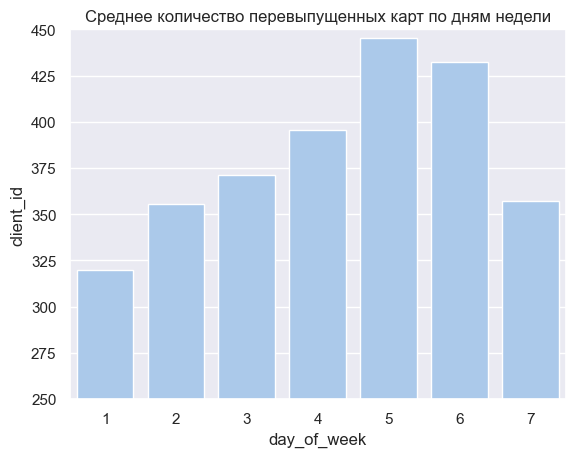

In [109]:
sns.barplot(first_red, x='day_of_week', y='client_id')
plt.ylim(250, 450)
plt.title('Среднее количество перевыпущенных карт по дням недели')
plt.show()

In [106]:
weekly_totals = first_redeem.groupby(['year', 'day_of_week'])['client_id'].sum().reset_index()
yearly_totals = first_redeem.groupby('year')['client_id'].sum().reset_index()
merged = pd.merge(weekly_totals, yearly_totals, on='year', suffixes=('', '_yearly'))
merged['percentage_share'] = (merged['client_id'] / merged['client_id_yearly']) * 100
merged['day_of_week'] = merged['day_of_week'].apply(lambda x: dwks[x])

В процентном отношении мы также видим. В понедельник происходит всего лишь 11-12 % перевыпусков карт, в то время как оформление новых карт происходит в понедельник в 14-15 % случаев.

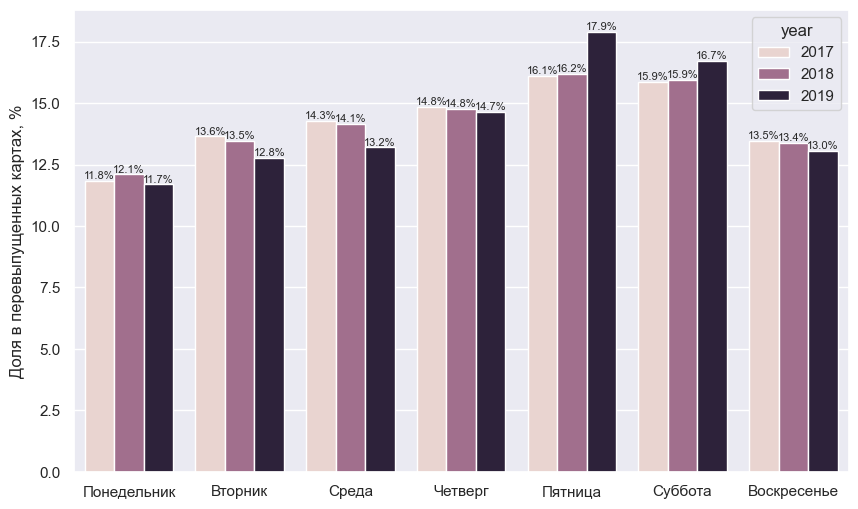

In [108]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(merged, x='day_of_week', y='percentage_share', hue='year')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=8)
plt.xlabel('')
plt.ylabel('Доля в перевыпущенных картах, %')
plt.show()

Посмотрим на возрастной состав клиентской базы.

In [119]:
clients[age]

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05,2018-01-04,45,U
1,000036f903,2017-04-10,2017-04-23,72,F
2,000048b7a6,2018-12-15,NaT,68,F
3,000073194a,2017-05-23,2017-11-24,60,F
4,00007c7133,2017-05-22,2018-12-31,67,U
...,...,...,...,...,...
400157,fffece623e,2018-05-13,2018-12-27,67,U
400158,ffff3dfff8,2018-11-01,2018-12-07,56,F
400159,ffffaab9da,2017-08-25,2017-12-08,23,F
400160,ffffeb5619,2017-12-05,NaT,62,U


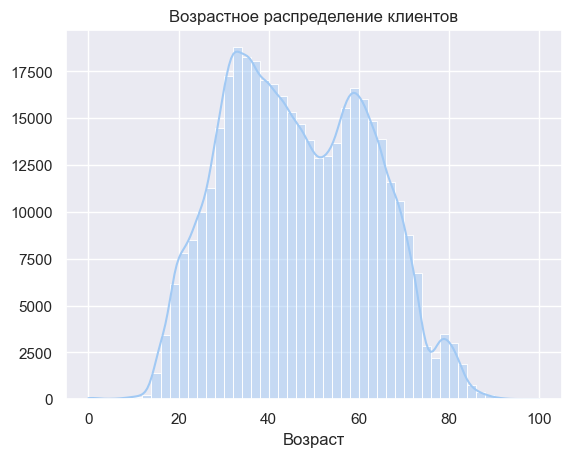

In [134]:
plt.title("Возрастное распределение клиентов")
sns.histplot(clients[(clients.age >= 0) & (clients.age <= 100)].age, bins=50, kde=True)
plt.xlabel('Возраст')
plt.ylabel('')
plt.show()

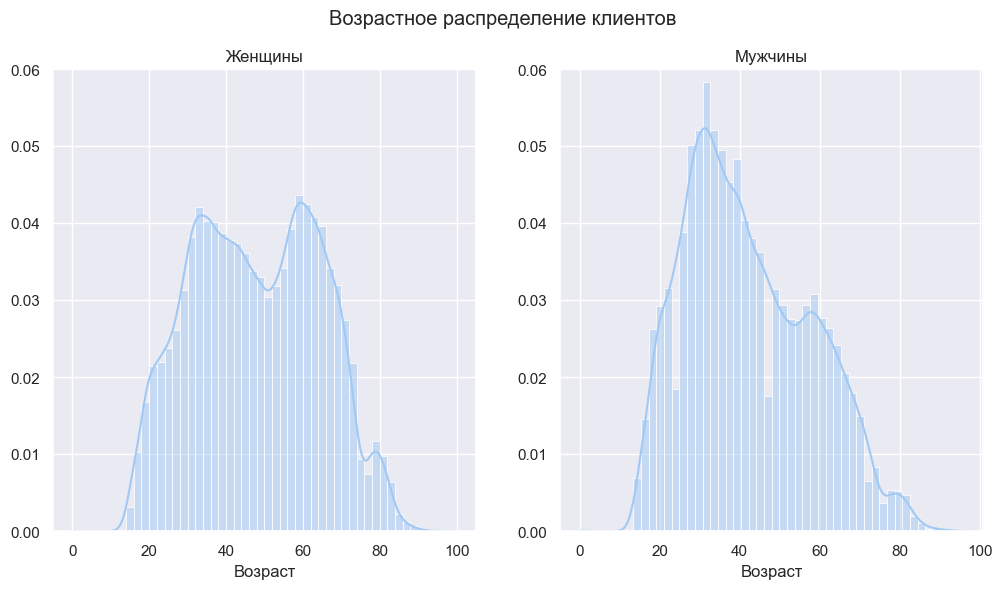

In [139]:
df_age = clients[(clients.age >= 0) & (clients.age <= 100)]


plt.figure(figsize=(12, 6))
plt.suptitle("Возрастное распределение клиентов")
plt.subplot(121)
plt.title('Женщины')
sns.histplot(df_age[df_age.gender == 'F'].age, bins=50, kde=True, stat='probability')
plt.ylim(0, 0.06)
plt.xlabel('Возраст')
plt.ylabel('')
plt.subplot(122)
plt.title('Мужчины')
sns.histplot(df_age[df_age.gender == 'M'].age, bins=50, kde=True, stat='probability')
plt.ylim(0, 0.06)
plt.xlabel('Возраст')
plt.ylabel('')
plt.show()

Можем видеть, что распределения для мужчин и женщин отличаются. Распределение тех, кто не указал свой пол, можно считать комбинацией двух предыдущих в некоторых пропорциях.

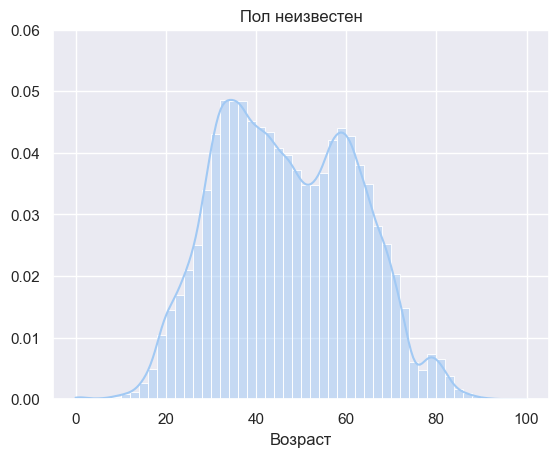

In [140]:
plt.title('Пол неизвестен')
sns.histplot(df_age[df_age.gender == 'U'].age, bins=50, kde=True, stat='probability')
plt.ylim(0, 0.06)
plt.xlabel('Возраст')
plt.ylabel('')
plt.show()